# Workflow
This analysis follows my typical approach - preprocess, explore, analyze, visualize tried combining network analysis with standard co-occurrence this time

1. Import and Preprocessing
2. Dataset exploration
3. Co-occurrence matrix construction
4. Graph
5. Plots
6. Report

<a id="loadlibraries"></a>
# `Load Libraries`
---

# ❓ Why are these libraries useful?
We need tools for data manipulation (pandas, numpy), visualization (matplotlib, seaborn),
graph analysis (networkx), and structure handling (collections, itertools)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
from itertools import combinations
from collections import Counter
import warnings
from networkx.algorithms.community import greedy_modularity_communities

# Sick of those FutureWarnings cluttering my output
warnings.filterwarnings('ignore')

# White grid looks cleaner for presenting to the team
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)  # found this size works well on my screen

<a id="loadlibraries"></a>
# ` Load and Preprocess Dataset`
---

# ❓ Why do we transform to long format?
To facilitate aggregation and filtering of document-term relations.
Melting makes life so much easier for downstream analysis.
https://pandas.pydata.org/docs/reference/api/pandas.melt.html

In [ ]:
print("Loading dataset...")
df = pd.read_csv("02_terms.csv")
df.head()


Loading dataset...


,DocNumber,advice,author,cold,computing,encourage,examples,information,help,lesson,...,positions,proposal,recommend,research,sentiment,slides,suggestion,tip,tutorial,users
0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,5,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
# Each row is a document. Binary values indicate if there are in the document or not
# kind of a sparse format but works ok for this dataset size
print("\n--- Dataset Overview ---")
print("Shape:", df.shape)
print("Column types:\n", df.dtypes)



--- Dataset Overview ---
Shape: (153, 22)
Column types:
 DocNumber      int64
advice         int64
author         int64
cold           int64
computing      int64
encourage      int64
examples       int64
information    int64
help           int64
lesson         int64
news           int64
opinion        int64
positions      int64
proposal       int64
recommend      int64
research       int64
sentiment      int64
slides         int64
suggestion     int64
tip            int64
tutorial       int64
users          int64
dtype: object


In [4]:
df.head()

,DocNumber,advice,author,cold,computing,encourage,examples,information,help,lesson,...,positions,proposal,recommend,research,sentiment,slides,suggestion,tip,tutorial,users
0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,3,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
4,5,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [5]:
df.columns


Index(['DocNumber', 'advice', 'author', 'cold', 'computing', 'encourage',
       'examples', 'information', 'help', 'lesson', 'news', 'opinion',
       'positions', 'proposal', 'recommend', 'research', 'sentiment', 'slides',
       'suggestion', 'tip', 'tutorial', 'users'],
      dtype='object')

In [ ]:
# Transform to long format for easier analysis
# This is way better than trying to work with the wide format when doing co-occurrences
df_long_format = df.melt(id_vars=['DocNumber'], 
                  var_name='term', 
                  value_name='frequency')
# Rename columns for clarity
df_long_format.columns = ['document_id', 'term', 'frequency']

# Remove rows with frequency zero (term not present)
# Zero frequencies are useless and just waste memory
df_long = df_long_format[df_long_format['frequency'] > 0]

# Reset index
df_long.reset_index(drop=True, inplace=True)

df_long.head()


,document_id,term,frequency
0,16,advice,1
1,18,advice,1
2,19,advice,1
3,20,advice,1
4,21,advice,1


In [ ]:
# Display information about the transformed data
print("Transformed data (first 5 rows):")
print(df_long.head())
print("\n➡️ Total number of rows:", df_long.shape[0])
print("➡️ Number of documents:", df_long['document_id'].nunique())
print("➡️ Number of terms:", df_long['term'].nunique())
print("➡️ Null values:", df_long.isnull().sum().sum())  # shouldn't be any but checking anyway

Transformed data (first 5 rows):
   document_id    term  frequency
0           16  advice          1
1           18  advice          1
2           19  advice          1
3           20  advice          1
4           21  advice          1

➡️ Total number of rows: 400
➡️ Number of documents: 139
➡️ Number of terms: 21
➡️ Null values: 0


<a id="loadlibraries"></a>
# ` Explore Dataset`
---

# ❓ What is the distribution of term usage?
Would expect a power law here - few terms used a lot, most used rarely
These distributions are usually skewed like crazy

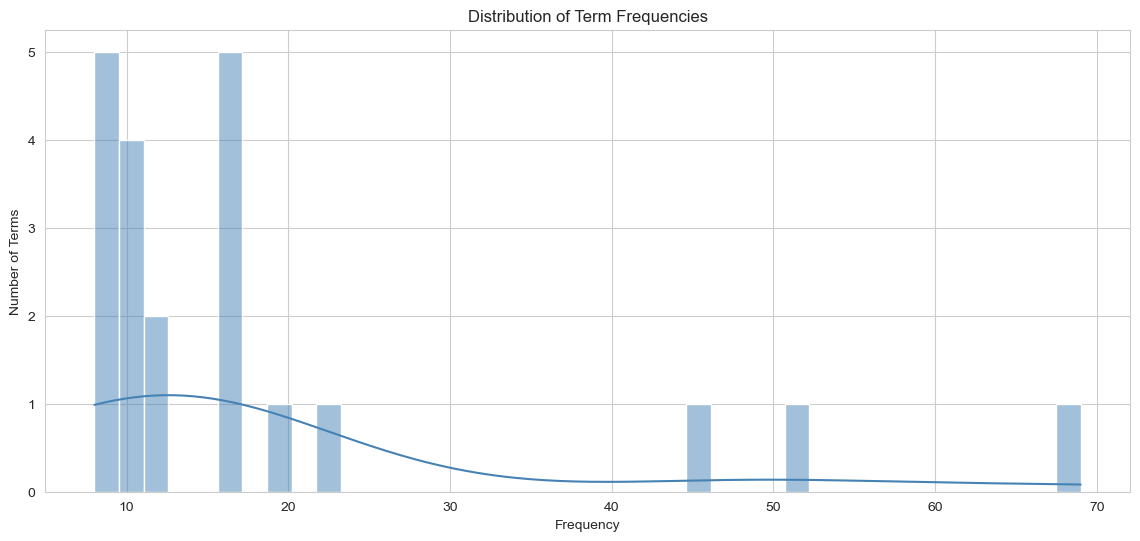

In [ ]:
term_freq = df_long.groupby('term')['frequency'].sum().sort_values(ascending=False)

# Histogram
plt.figure(figsize=(14, 6))
sns.histplot(term_freq, bins=40, kde=True, color='steelblue')  # 40 bins seemed to work best
plt.title('Distribution of Term Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Number of Terms')
plt.grid(True)
plt.savefig("fig_A.png")
plt.show()


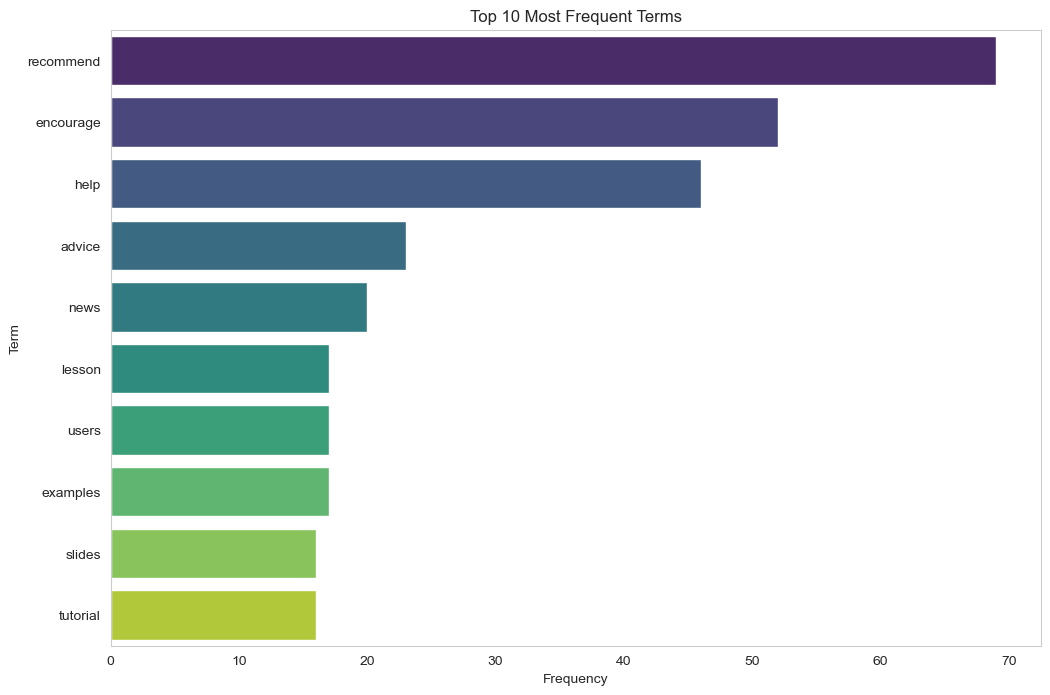

In [ ]:
# Top 10 terms
# Viridis colormap is my go-to - colorblind friendly and looks professional
plt.figure(figsize=(12, 8))
sns.barplot(x=term_freq.head(10).values, y=term_freq.head(10).index, palette='viridis')
plt.title('Top 10 Most Frequent Terms')
plt.xlabel('Frequency')
plt.ylabel('Term')
plt.grid(axis='x')
plt.savefig("fig_B.png")

plt.show()

# ❓ Which documents are most populated with terms?
There's always that one document that's an outlier - highlighting it in red

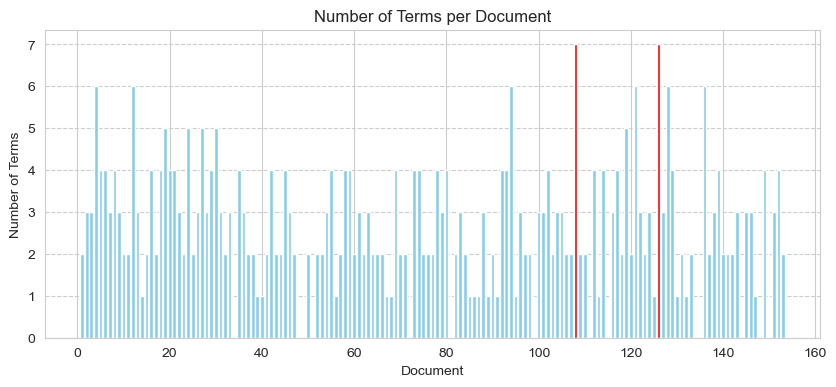

In [ ]:
doc_term_count = df_long.groupby('document_id').size().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
colors = ['red' if val == doc_term_count.max() else 'skyblue' for val in doc_term_count]
plt.bar(doc_term_count.index, doc_term_count.values, color=colors)
plt.title('Number of Terms per Document')
plt.xlabel('Document')
plt.ylabel('Number of Terms')
plt.grid(axis='y', linestyle='--')  # dashed grid looks nicer here
plt.savefig("fig_C.png")

plt.show()

<a id="loadlibraries"></a>
# ` Co-occurrence Matrix`
---

# ❓ Why compute co-occurrences?
To discover terms that often appear together, indicating a semantic or topical connection
This part was tricky - had to use combinations() to avoid counting pairs twice

In [ ]:
print("\n--- Co-occurrence Analysis ---")
# Group by document to get list of terms in each document
doc_term_map = df_long.groupby('document_id')['term'].apply(list)

# Calculate term co-occurrences
co_occurrence = Counter()
for terms in doc_term_map:
    # Use set to avoid counting duplicates within the same document
    # Learned this the hard way after getting weird results first time around
    pairs = combinations(set(terms), 2)
    co_occurrence.update(pairs)

# Convert to DataFrame
co_df = pd.DataFrame(co_occurrence.items(), columns=['pair', 'count'])
co_df[['term1', 'term2']] = pd.DataFrame(co_df['pair'].tolist(), index=co_df.index)
co_df.drop(columns=['pair'], inplace=True)
co_df = co_df[['term1', 'term2', 'count']]

# Display the strongest co-occurrences
print("Top 10 strongest term co-occurrences:")
print(co_df.sort_values(by='count', ascending=False).head(10))

# Find least connected terms
# Worth checking these too - sometimes reveals interesting patterns
if co_df['count'].min() == 0:
    least_connected = co_df[co_df['count'] == 0].head(5)
else:
    least_connected = co_df.sort_values(by='count').head(5)
    
print("\nLeast connected term pairs:")
print(least_connected)



--- Co-occurrence Analysis ---
Top 10 strongest term co-occurrences:
         term1      term2  count
40   encourage       help     31
25   encourage  recommend     18
78   recommend   examples     14
6        users  recommend     13
45  suggestion     lesson     11
23        news  recommend     11
84        help  recommend     11
54   recommend     advice     11
48      advice     lesson     10
44  suggestion     advice      9

Least connected term pairs:
          term1   term2  count
165   recommend   users      1
53   suggestion  slides      1
139        cold  lesson      1
103    examples  slides      1
147   encourage    cold      1


<a id="loadlibraries"></a>
# ` Network Graph Analysis `
---

Creating a network from co-occurrences - probably the most interesting part
This helps visualize clusters and central terms better than tables

In [ ]:
G = nx.Graph()

# Add nodes (terms)
terms = pd.unique(co_df[['term1', 'term2']].values.ravel('K'))
G.add_nodes_from(terms)

# Add edges (co-occurrences)
for _, row in co_df.iterrows():
    G.add_edge(row['term1'], row['term2'], weight=row['count'])

print(f"Nodes in graph: {G.number_of_nodes()}")
print(f"Edges in graph: {G.number_of_edges()}")

Nodes in graph: 21
Edges in graph: 128


In [ ]:
# Metrics
# Degree centrality = how many connections
# Betweenness = how often a node is on shortest paths between other nodes
# Had some memory issues with closeness centrality so left it out
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
communities = list(greedy_modularity_communities(G))

nx.set_node_attributes(G, degree_centrality, 'degree_centrality')
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

# Map nodes to their community IDs
community_map = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_map[node] = i
nx.set_node_attributes(G, community_map, 'community')


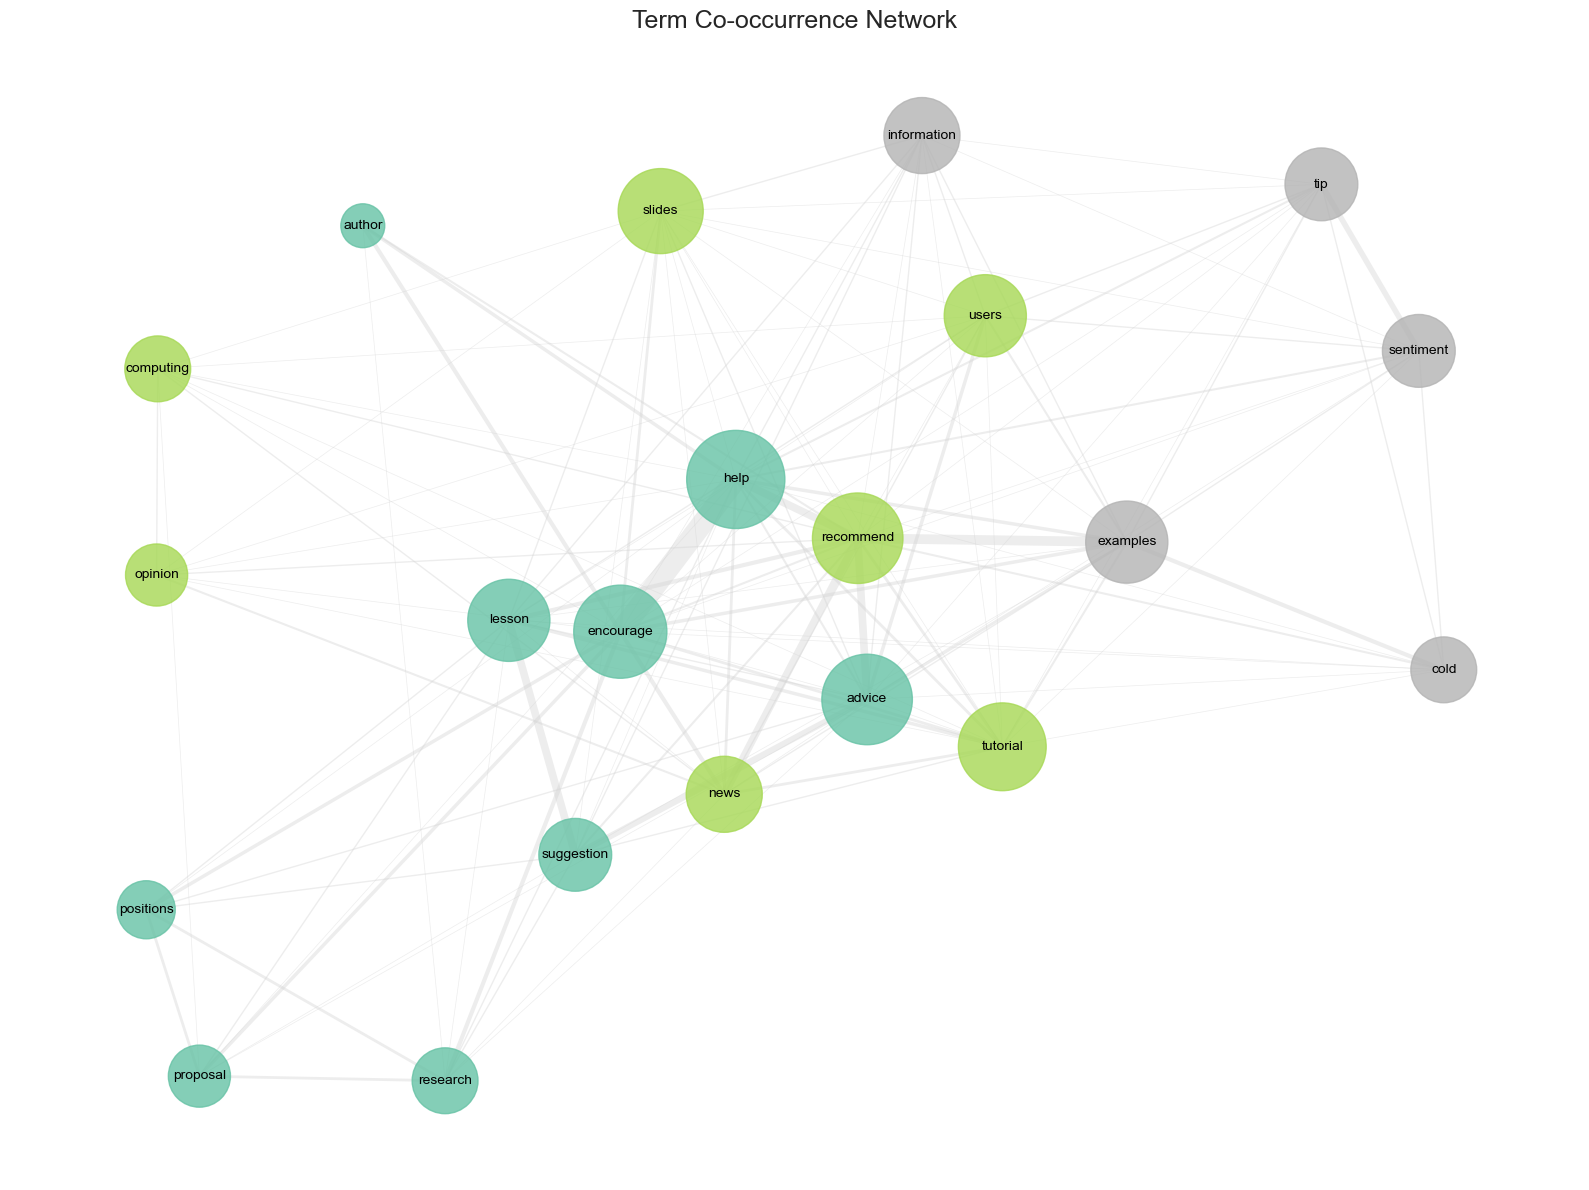

In [ ]:

plt.figure(figsize=(16, 12))

# Set node positions using spring layout
# Using fixed seed makes the layout reproducible
# k=0.5 gives enough separation without nodes flying off to corners
layout = nx.spring_layout(G, seed=42, k=0.5)

# Color nodes by community
colors = [community_map[node] for node in G.nodes()]

# Size nodes by degree centrality
# Multiplier of 5000 makes the important nodes stand out better
sizes = [5000 * degree_centrality[node] for node in G.nodes()]

# Draw nodes
nx.draw_networkx_nodes(G, layout,
                       node_color=colors,
                       node_size=sizes,
                       cmap=plt.cm.Set2,  # Set2 palette distinguishes communities well
                       alpha=0.8)

# Draw edges with width based on weight
# Made these lighter so they don't overwhelm the nodes
edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
nx.draw_networkx_edges(G, layout, 
                       width=edge_weights,
                       edge_color='lightgray', 
                       alpha=0.4)

# Draw labels
nx.draw_networkx_labels(G, layout,
                        font_size=10,
                        font_family='sans-serif')

plt.title("Term Co-occurrence Network", fontsize=18)
plt.axis('off')
plt.tight_layout()
plt.show()
plt.savefig("fig_D.png")
plt.close()

# ❓ Which terms dominate the network the most?

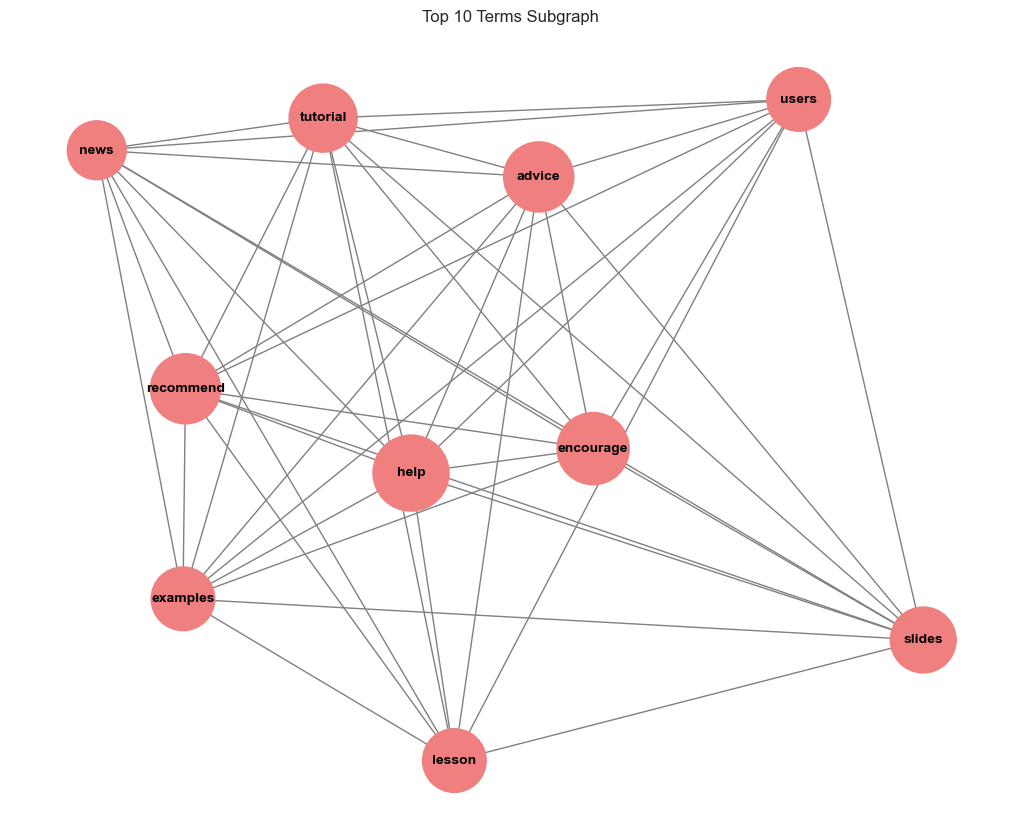

In [ ]:
# 🔍 Network of the Top 10 Most Frequent Terms
# Creating a smaller network of just the top terms makes it easier to see their relationships
top_10 = term_freq.head(10).index.tolist()
G_top10 = G.subgraph(top_10)

pos = nx.spring_layout(G_top10, seed=42)
plt.figure(figsize=(10, 8))
nx.draw(G_top10, pos, with_labels=True,
        node_size=[3000 * degree_centrality[n] for n in G_top10.nodes()],
        node_color='lightcoral', edge_color='gray',  # red stands out nicely
        font_size=10, font_weight='bold')
plt.title("Top 10 Terms Subgraph")
plt.axis('off')
plt.savefig("fig_E.png")

plt.show()


# ❓ What does the largest community look like?

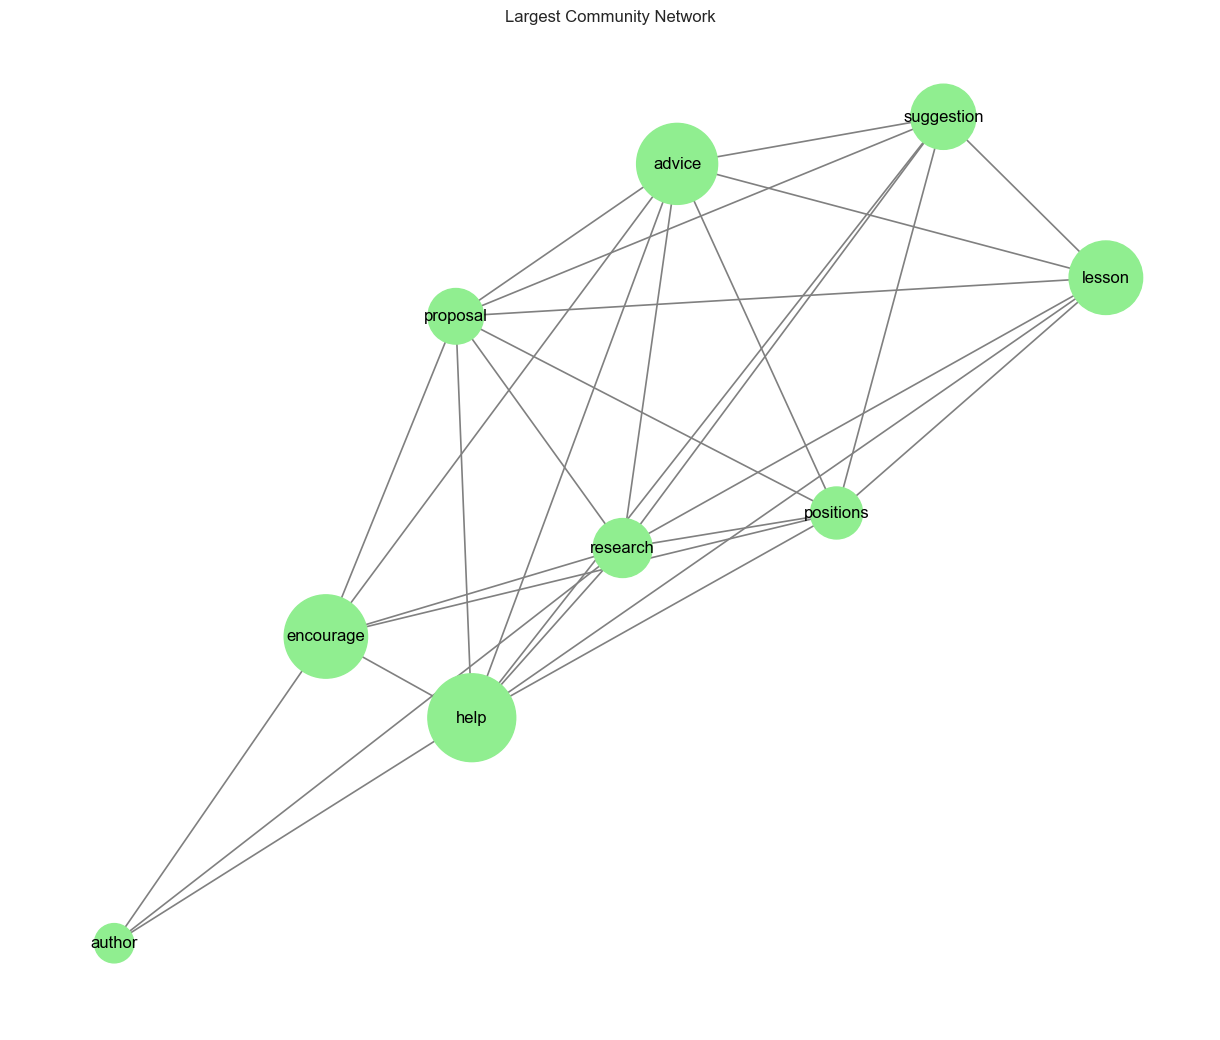

In [ ]:
# 🔍 Visualizing the Largest Community Subgraph
# This often reveals the dominant theme of the corpus
largest_comm = max(communities, key=len)
G_largest_comm = G.subgraph(largest_comm)

# Changed seed to 24 here to avoid layout issues with this specific subgraph
pos = nx.spring_layout(G_largest_comm, seed=24)
plt.figure(figsize=(12, 10))
nx.draw(G_largest_comm, pos, with_labels=True,
        node_color='lightgreen',  # green for largest community
        node_size=[4000 * degree_centrality[n] for n in G_largest_comm.nodes()],
        edge_color='gray', width=1.2)
plt.title("Largest Community Network")
plt.axis('off')
plt.savefig("fig_F.png")

plt.show()

<a id="loadlibraries"></a>
# ` HeatMap `
---

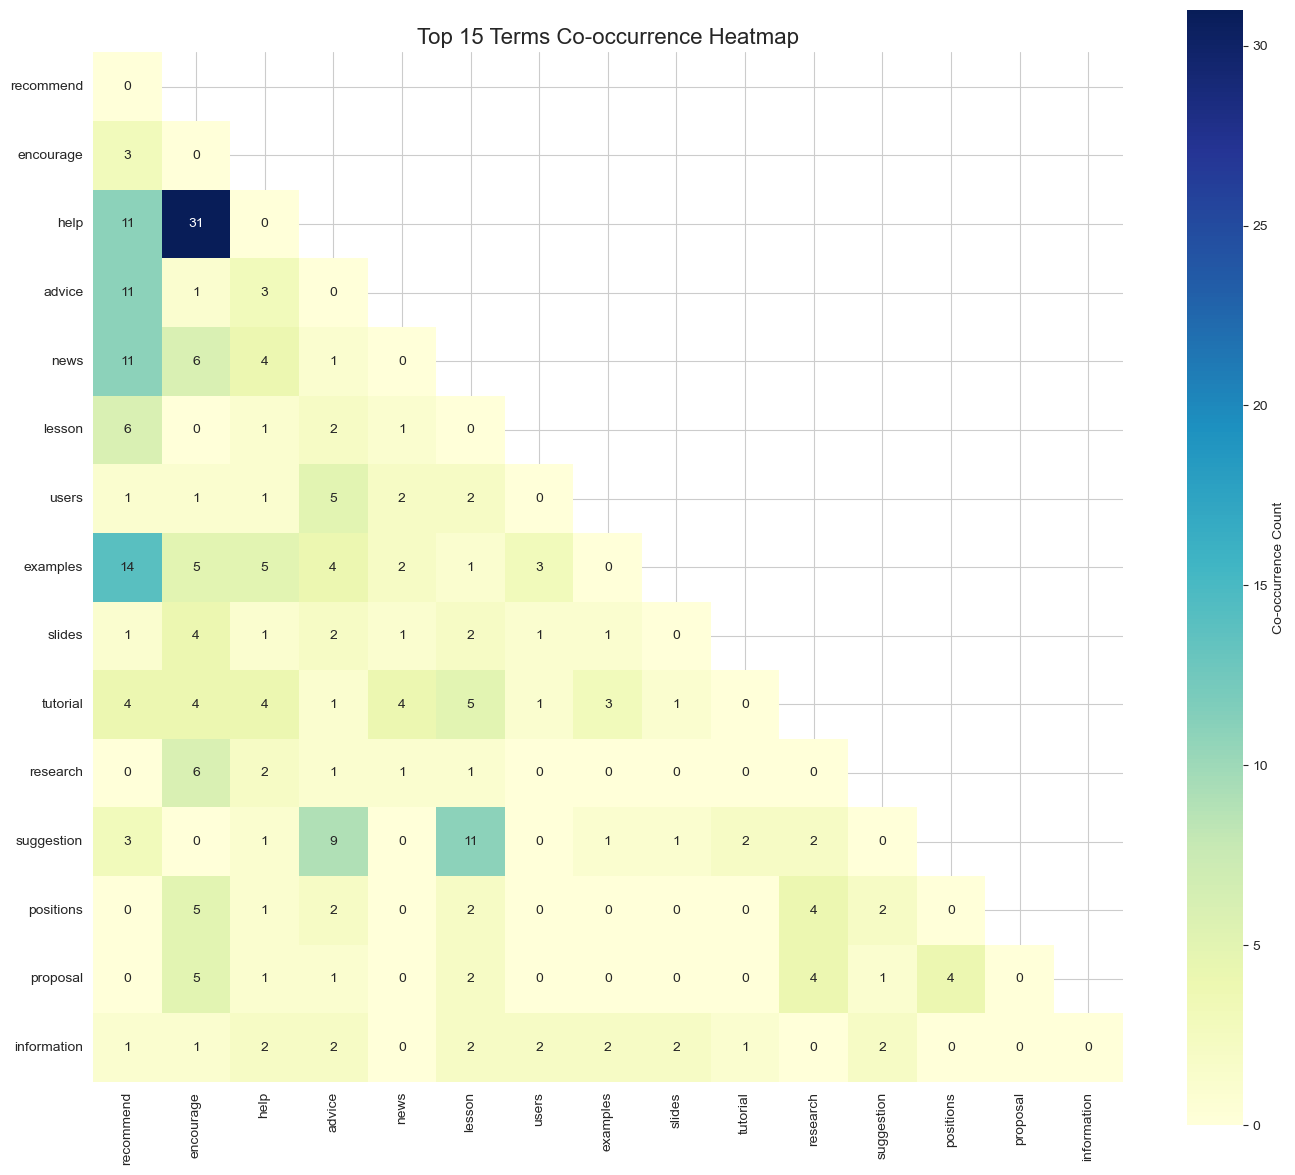

In [ ]:
# Heatmap gives another perspective on co-occurrences
# Less cluttered than network for seeing specific pair relationships

# Get top N terms by frequency
# More than 15 makes the heatmap too crowded to read
top_n_terms = 15
top_terms_list = term_freq.head(top_n_terms).index.tolist()

# Create an empty square matrix for co-occurrences
co_matrix = np.zeros((top_n_terms, top_n_terms))

# Create a dictionary for fast lookup
# This speeds things up considerably compared to pandas lookups
term_to_index = {term: i for i, term in enumerate(top_terms_list)}

# Fill the matrix with co-occurrence counts
for _, row in co_df.iterrows():
    term1, term2 = row['term1'], row['term2']
    count = row['count']
    
    # Check if both terms are in our top terms list
    if term1 in term_to_index and term2 in term_to_index:
        i = term_to_index[term1]
        j = term_to_index[term2]
        co_matrix[i, j] = count
        co_matrix[j, i] = count  # Make it symmetric

# Create a DataFrame from the matrix
co_matrix_df = pd.DataFrame(co_matrix, index=top_terms_list, columns=top_terms_list)

# Plot heatmap
plt.figure(figsize=(14, 12))
# Mask for lower triangular - avoids redundant info since matrix is symmetric
mask = np.triu(np.ones_like(co_matrix_df, dtype=bool), k=1)
sns.heatmap(
    co_matrix_df, 
    annot=True,  # show actual values
    fmt='.0f',   # no decimals needed
    cmap='YlGnBu',  # blue-green colormap works well for this
    mask=mask,
    square=True,
    cbar_kws={'label': 'Co-occurrence Count'}
)
plt.title(f'Top {top_n_terms} Terms Co-occurrence Heatmap', fontsize=16)
plt.tight_layout()
plt.show()
plt.savefig("fig_G.png")  # Fixed missing closing parenthesis here
plt.close()



In [18]:
print("\n--- Summary ---")
print(f"    Most frequent term: {term_freq.idxmax()} ({term_freq.max()} times)")
print(f"    Most central term (degree): {max(degree_centrality.items(), key=lambda x: x[1])}")
print(f"    Most central term (betweenness): {max(betweenness_centrality.items(), key=lambda x: x[1])}")
strongest = co_df.sort_values(by='count', ascending=False).iloc[0]
print(f"    Strongest pair: {strongest['term1']} + {strongest['term2']} ({strongest['count']})")
print(f"    Number of communities: {len(communities)}")
print(f"    Largest community size: {len(max(communities, key=len))}")
print(f"    Average number of terms per document: {doc_term_count.mean():.2f}")



--- Summary ---
    Most frequent term: recommend (69 times)
    Most central term (degree): ('help', 1.0)
    Most central term (betweenness): ('help', 0.09567428185849236)
    Strongest pair: encourage + help (31)
    Number of communities: 3
    Largest community size: 9
    Average number of terms per document: 2.88
